# HW 3: Поиск аномалий

1. Проведите небольшой EDA (гистограммы и описательные статистики - обязательно).
2. Воспользуйтесь процентом аномалий, подсчитанным по переменной Class, как "экспертной оценкой" загрязненности нашего датасета.
3. Попробуйте построить различные модели и алгоритмы, разобранные на занятии, используя полученную экспертную оценку для настройки параметров.
4. Воспользуйтесь стандартными методами оценки качества бинарной классификации (особенно хорошо подойдёт classification report и confusion matrix), и, используя предсказания моделей и переменную Class, проверьте, действительно ли модели справляются со своей задачей и на сколько хорошо они это делают.
5. При помощи tSNE и/или UMAP, постройте сжатое представление исходных данных и проверьте, действительно ли аномалии лежат достаточно далеко от основной массы точек.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from umap import UMAP
import re

# 1.Dataset

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

### Контекст
Важно, чтобы компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции по кредитным картам, чтобы с клиентов не взималась плата за товары, которые они не покупали.

### Описание Dataset

- **Time - количество секунд между каждой транзакцией и первой транзакцией**
- **Amount - Сумма транзакции**
- **Class - Мошенническая транзакция или нет: 1 - мошенническая и 0 - нет**

Набор данных содержит транзакции, совершенные европейскими держателями карт по кредитным картам в сентябре 2013 года.
В этом наборе данных представлены транзакции, произошедшие за два дня, где у нас есть 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничества) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. 
Характеристики V1, V2,… V28 являются основными компонентами, полученными с помощью PCA, единственные функции, которые не были преобразованы с помощью PCA, - это «Time» и «Amount». 
Функция «Time» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция «Amount» представляет собой сумму транзакции. Эту функцию можно использовать для обучения с учетом затрат в зависимости от примера. Функция «Class» — это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Учитывая коэффициент дисбаланса классов, мы рекомендуем измерять точность с помощью площади под кривой точности-отзыва (AUPRC). Точность матрицы неточностей не имеет значения для несбалансированной классификации.

### Базовые статистики

In [4]:
data.describe().round(2)

Time         V1         V2         V3         V4         V5  \
count  284807.00  284807.00  284807.00  284807.00  284807.00  284807.00   
mean    94813.86       0.00       0.00      -0.00       0.00       0.00   
std     47488.15       1.96       1.65       1.52       1.42       1.38   
min         0.00     -56.41     -72.72     -48.33      -5.68    -113.74   
25%     54201.50      -0.92      -0.60      -0.89      -0.85      -0.69   
50%     84692.00       0.02       0.07       0.18      -0.02      -0.05   
75%    139320.50       1.32       0.80       1.03       0.74       0.61   
max    172792.00       2.45      22.06       9.38      16.88      34.80   

              V6         V7         V8         V9  ...        V21        V22  \
count  284807.00  284807.00  284807.00  284807.00  ...  284807.00  284807.00   
mean        0.00      -0.00       0.00      -0.00  ...       0.00      -0.00   
std         1.33       1.24       1.19       1.10  ...       0.73       0.73   
min       -26.16     -43.56     -73.22     -13.43  ...     -34.83     -10.93   
25%        -0.77      -0.55      -0.21      -0.64  ...      -0.23      -0.54   
50%        -0.27       0.04       0.02      -0.05  ...      -0.03       0.01   
75%         0.40       0.57       0.33       0.60  ...       0.19       0.53   
max        73.30     120.59      20.01      15.59  ...      27.20      10.50   

             V23        V24        V25        V26        V27        V28  \
count  284807.00  284807.00  284807.00  284807.00  284807.00  284807.00   
mean        0.00       0.00       0.00       0.00      -0.00      -0.00   
std         0.62       0.61       0.52       0.48       0.40       0.33   
min       -44.81      -2.84     -10.30      -2.60     -22.57     -15.43   
25%        -0.16      -0.35      -0.32      -0.33      -0.07      -0.05   
50%        -0.01       0.04       0.02      -0.05       0.00       0.01   
75%         0.15       0.44       0.35       0.24       0.09       0.08   
max        22.53       4.58       7.52       3.52      31.61      33.85   

          Amount      Class  
count  284807.00  284807.00  
mean       88.35       0.00  
std       250.12       0.04  
min         0.00       0.00  
25%         5.60       0.00  
50%        22.00       0.00  
75%        77.16       0.00  
max     25691.16       1.00  

[8 rows x 31 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# 2. EDA

In [6]:
# Проверяем, есть ли пропуски в данных.
data.isnull().sum().max()

0

Пропусков нет

In [7]:
data_columns = list(data.columns)
data.shape

(284807, 31)

Dataset очень большой, попробуем его уменьшить

In [8]:
# Пройдемся по всем столбцам и конвертируем данные из float64 в float32
for col in data.columns:
    if data[col].dtype == 'float64':
        data[col] = data[col].astype('float32')

In [9]:
data['Class'] = data['Class'].astype('float32')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

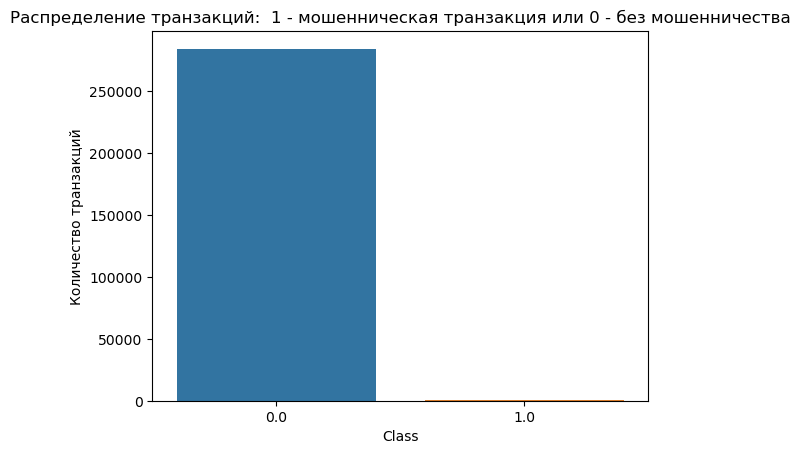

In [11]:
# Визуализация
score_counts = data.Class.value_counts()
sns.barplot(x = score_counts.index, y = score_counts.values)
plt.title('Распределение транзакций:  1 - мошенническая транзакция или 0 - без мошенничества')
plt.ylabel('Количество транзакций')
plt.xlabel('Class');

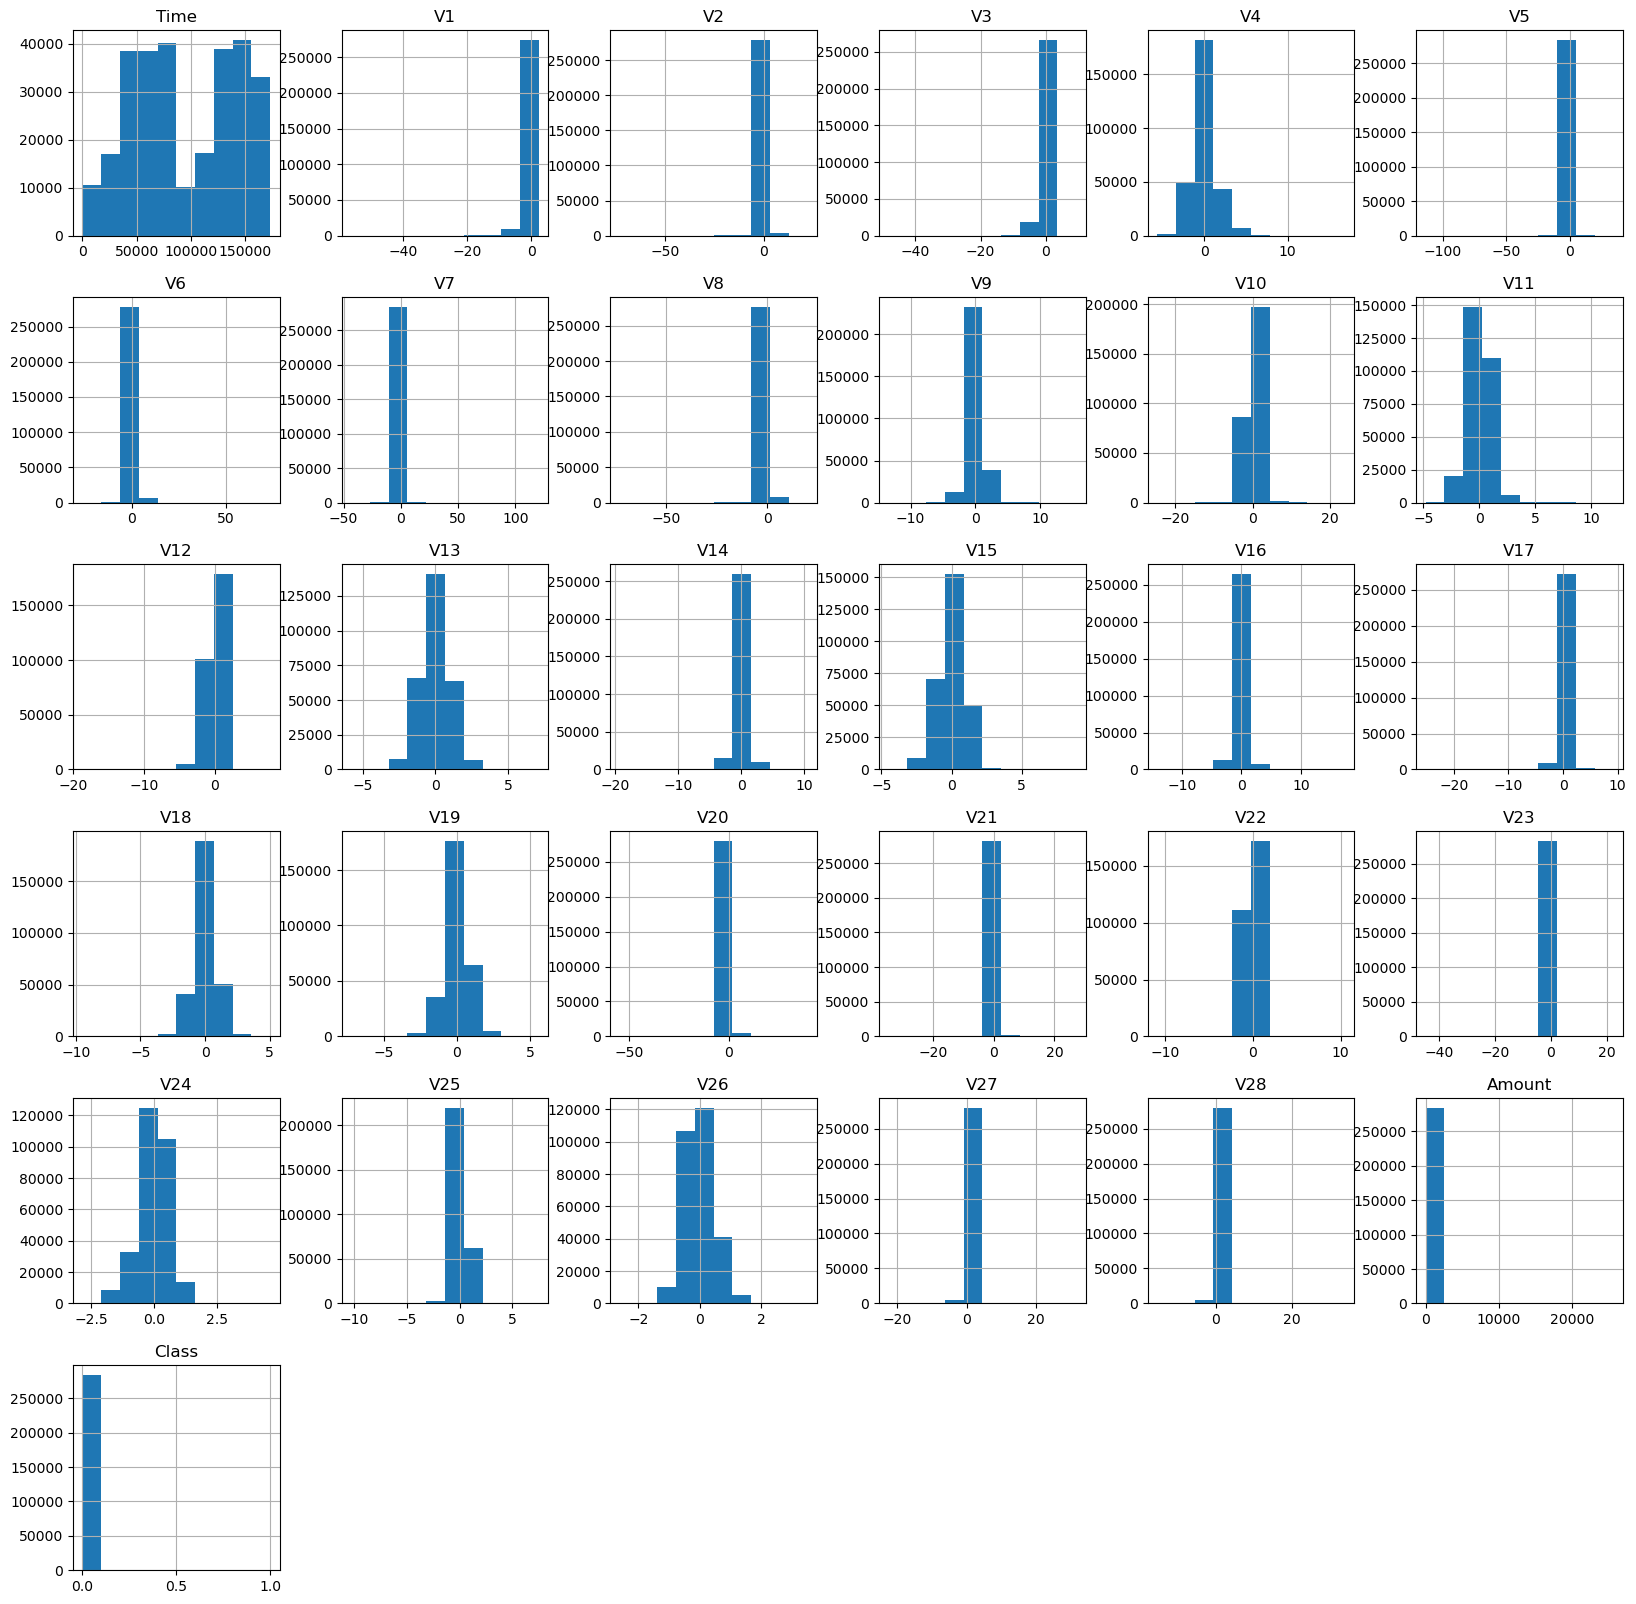

In [13]:
data.hist(figsize=(20, 20));

#### Корреляция

<Axes: >

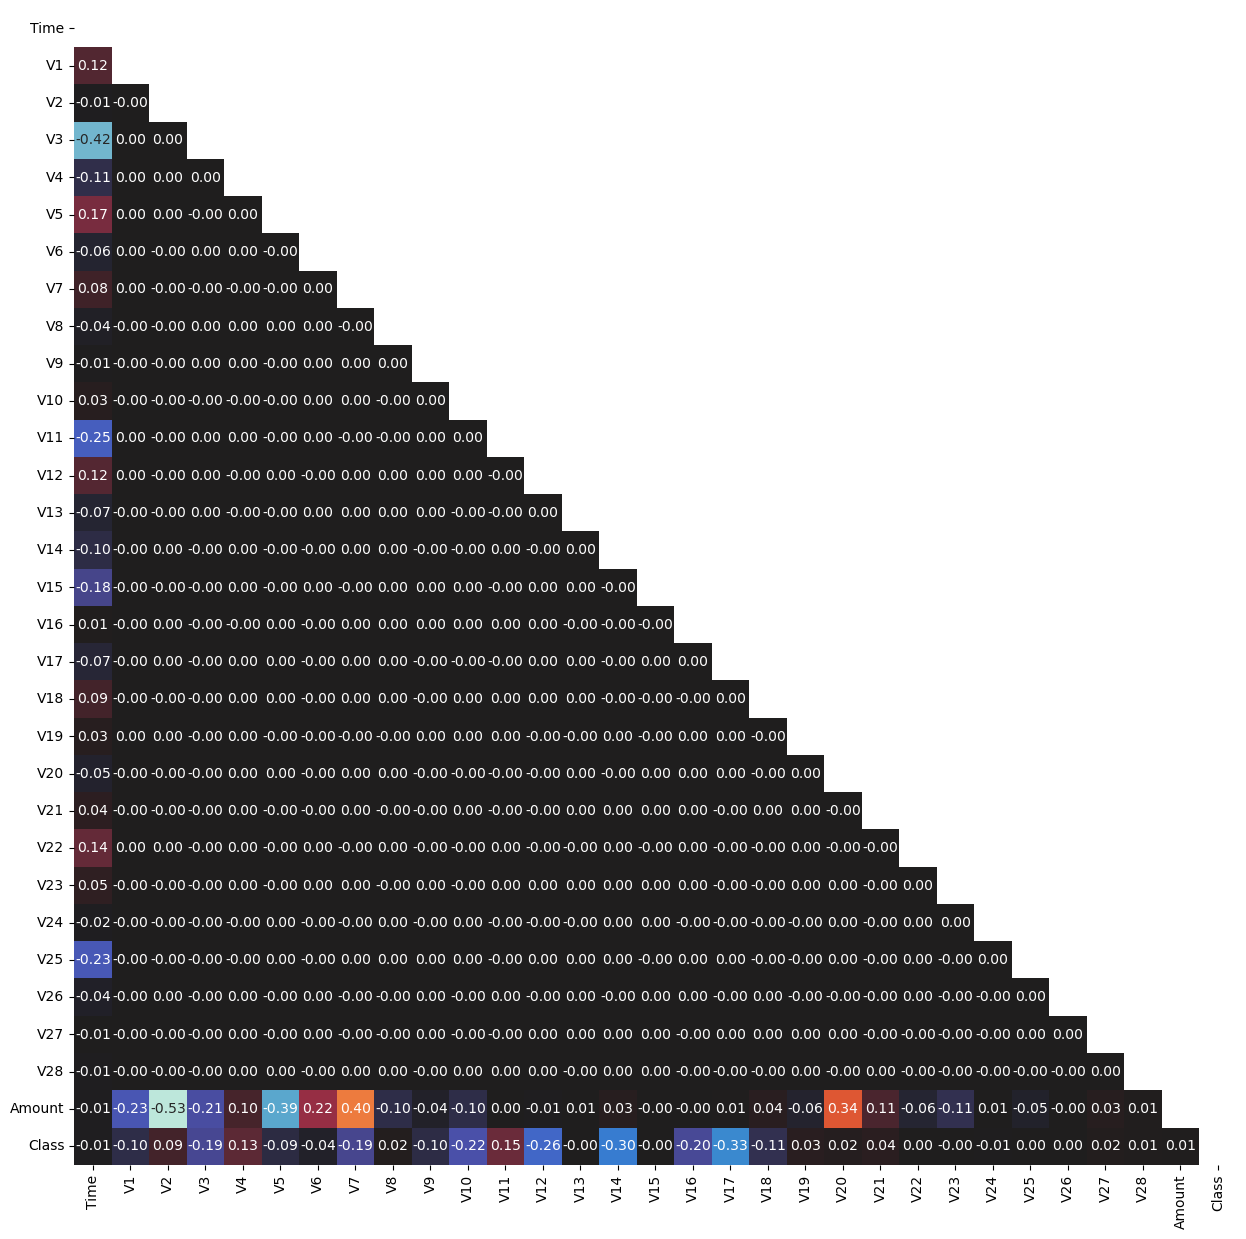

In [14]:
plt.figure(figsize=(15,15))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0)

In [15]:
high_corr = [
    column for column in lower.columns if any((lower[column] > 0.32)|(lower[column] < -0.32))
]
high_corr

['Time', 'V2', 'V5', 'V7', 'V17', 'V20']

In [16]:
other_features = [col for col in data.columns if col not in high_corr and col!='quality']

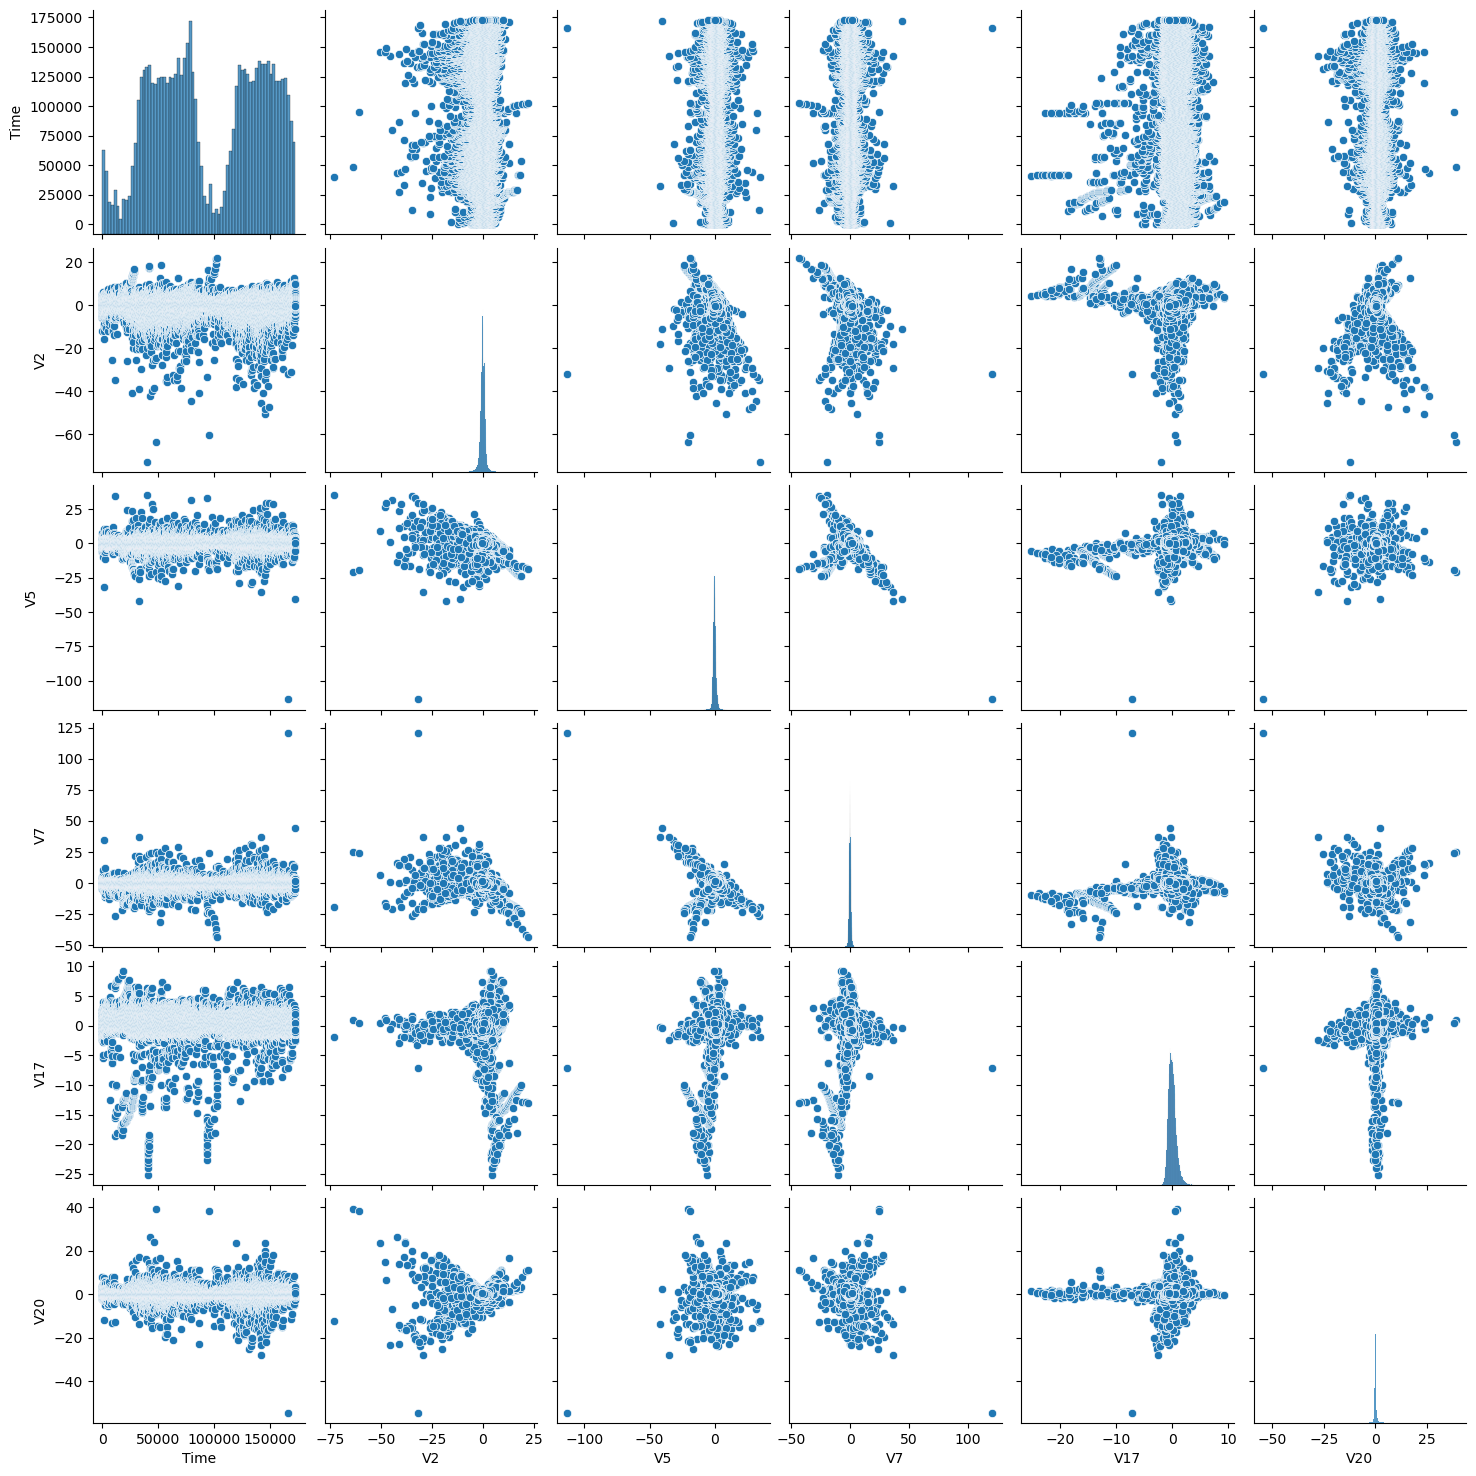

In [17]:
sns.pairplot(data[high_corr])

# 3. Рассчитаем процент аномалий, подсчитанный по переменной Class, как "экспертной оценкой" загрязненности нашего датасета.

In [18]:
data.loc[data['Class'] == 1].shape[0]

492

Всего 492 случая мошенничества

Посмотрим распределения классов в наборе данных:

In [19]:
data["Class"].value_counts(normalize=True) * 100

0.0    99.827251
1.0     0.172749
Name: Class, dtype: float64

Класс 0 (без мошенничества0 = 99,83% Класс 1 (мошеннические транзакции) = 0,17% Большинство транзакций не являются мошенническими. Поэтому перед обучением любой модели требуется предварительная обработка, чтобы избежать переопределений.

# 4.Предобработка данных

Приведем признаки к одному масштабу, поскольку не все алгоритмы машинного обучения могут хорошо работать с данными из разного диапазона. 

In [20]:
from sklearn.preprocessing import MinMaxScaler
# Нормализация значений признаков
X_scaled = MinMaxScaler().fit_transform(data.iloc[:, :-1]) # X
data_scaled = pd.DataFrame(X_scaled, columns=data.iloc[:, :-1].columns)
data_scaled['Class'] = data.iloc[:, -1] # Y

Количество наблюдений в исходных данных составляет 284 806, и даже после применения операции по трансформации float, int 64 в 32, файл имеет размер 34Мб. Поэтому для моделирования и поиска выбросов возьмем только их  часть. Предполагаем, что полученная случайная выборка является репрезентативной выборкой для исходных данных,но проверим это.

In [21]:
from sklearn.model_selection import train_test_split
# Формирование стратифицированной выборки из исходных данных
X_samples, _, Y_samples, _ = train_test_split(X_scaled, data_scaled['Class'], train_size=0.04, stratify=data_scaled['Class'],
                                              random_state=42)

# Вывод доли аномалий от общего числа транзакций
print('Процент аномальных транзакций: {:.2%}'.format(data_scaled['Class'].mean()))
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))

Процент аномальных транзакций: 0.17%
Процент аномальных транзакций в выборке: 0.18%


# 5. Поиск аномалий

## 4.1. Метод IQR -  Межквартильное отклонение

In [22]:
# Формирование матрицы выбросов
quantile_outliers = []
for i in range(3, 11):
    up_bound, low_bound = np.quantile(X_samples, [0.8, 0.2], axis=0)
    up_bound, low_bound = [up_bound, low_bound] + np.array([[i], [-i]]) * (up_bound - low_bound)
    quantile_outliers.append(np.where((X_samples < low_bound) | (X_samples > up_bound), 1, 0).any(axis=1))

# Подсчет количества и процента выбросов для разного межквартильного расстояния
sum_list = np.array(quantile_outliers).sum(axis=1)
mean_list = np.array(quantile_outliers).mean(axis=1)

# Сохраняем значения для межквартильного расстояния с наименьшим процентом выбросов
quantile_outliers = np.array(quantile_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('Количество выбросов в выборке для {} IRQ: {}'.format(sum_list.argmin() + 3, sum_list.min()))
print('Процент выбросов в выборке для {} IRQ: {:.2%}'.format(mean_list.argmin() + 3, mean_list.min()))

Процент аномальных транзакций в выборке: 0.18%
Количество выбросов в выборке для 10 IRQ: 251
Процент выбросов в выборке для 10 IRQ: 2.20%


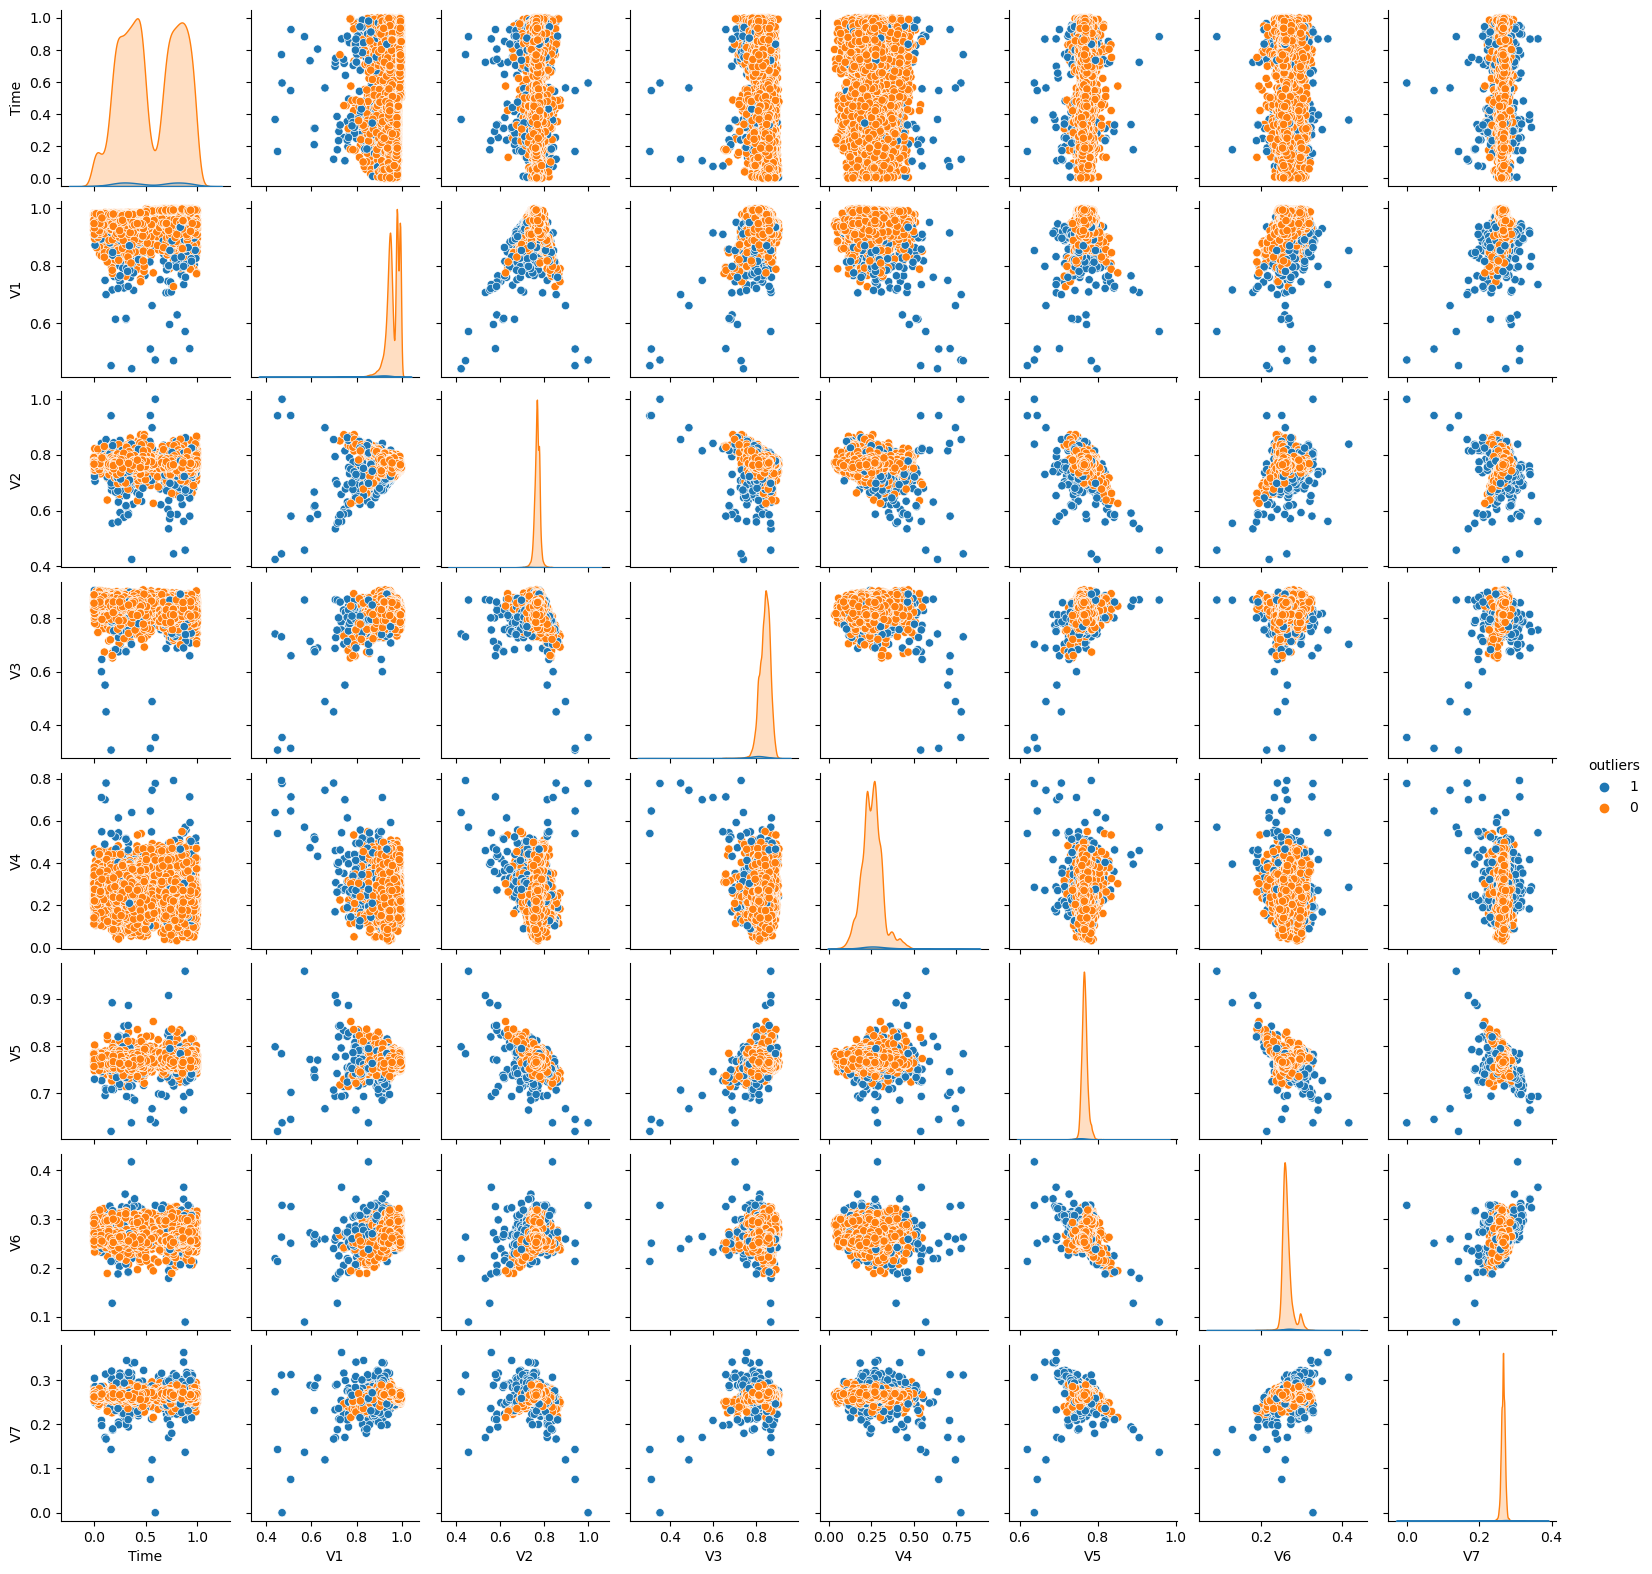

In [43]:
# Формирование матрицы транзакций с атрибутом выброса
# Число отображаемых признаков в матрице рассеивания
num_features = 8
tr_matrix = np.hstack((X_samples[:, :num_features], quantile_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*data.columns[:num_features], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()

# 5.2 DBSCAN

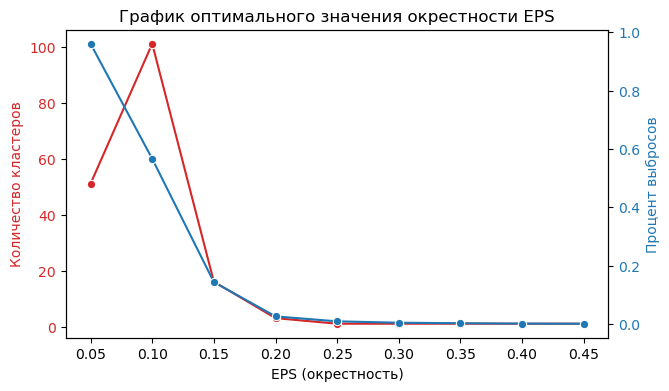

In [23]:
# Определение переменных
num_clusters = []
per_anomalies = []

# Построение модели для поиска оптимального значения окрестности EPS
for i in np.arange(0.05, 0.5, 0.05):
    model = DBSCAN(eps=i, n_jobs=-1).fit(X_samples)
    num_clusters.append(len(np.unique(model.labels_)) - 1)
    per_anomalies.append(np.where(model.labels_==-1, 1, 0).sum() / len(model.labels_))
    
# Определение основных объектов диаграмм
fig, axes = plt.subplots(1, 1, figsize=(7,4))

# Построение графика зависимости процента выбросов от количества кластеров
sns.lineplot(x=np.arange(0.05, 0.5, 0.05), y=num_clusters, marker='o', ax=axes, color='tab:red')
percent_axes = sns.lineplot(x=np.arange(0.05, 0.5, 0.05), y=per_anomalies, marker='o', ax=axes.twinx(), color='tab:blue')

# Вывод заголовка диаграмм и подписей осей
axes.set(title='График оптимального значения окрестности EPS', xlabel='EPS (окрестность)')
axes.set_ylabel('Количество кластеров', color='tab:red')
axes.tick_params(axis='y', labelcolor='tab:red')
percent_axes.set_ylabel('Процент выбросов', color='tab:blue')
percent_axes.tick_params(axis='y', labelcolor='tab:blue')

# Вывод диаграмм
plt.show()

In [24]:
# Формирование матрицы выбросов
model = DBSCAN(eps=0.3, n_jobs=-1).fit(X_samples)
dbscan_outliers = np.where(model.labels_==-1, 1, 0)

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('Количество выбросов в выборке: {}'.format(dbscan_outliers.sum()))
print('Процент выбросов в выборке: {:.2%}'.format(dbscan_outliers.mean()))

Процент аномальных транзакций в выборке: 0.18%
Количество выбросов в выборке: 49
Процент выбросов в выборке: 0.43%


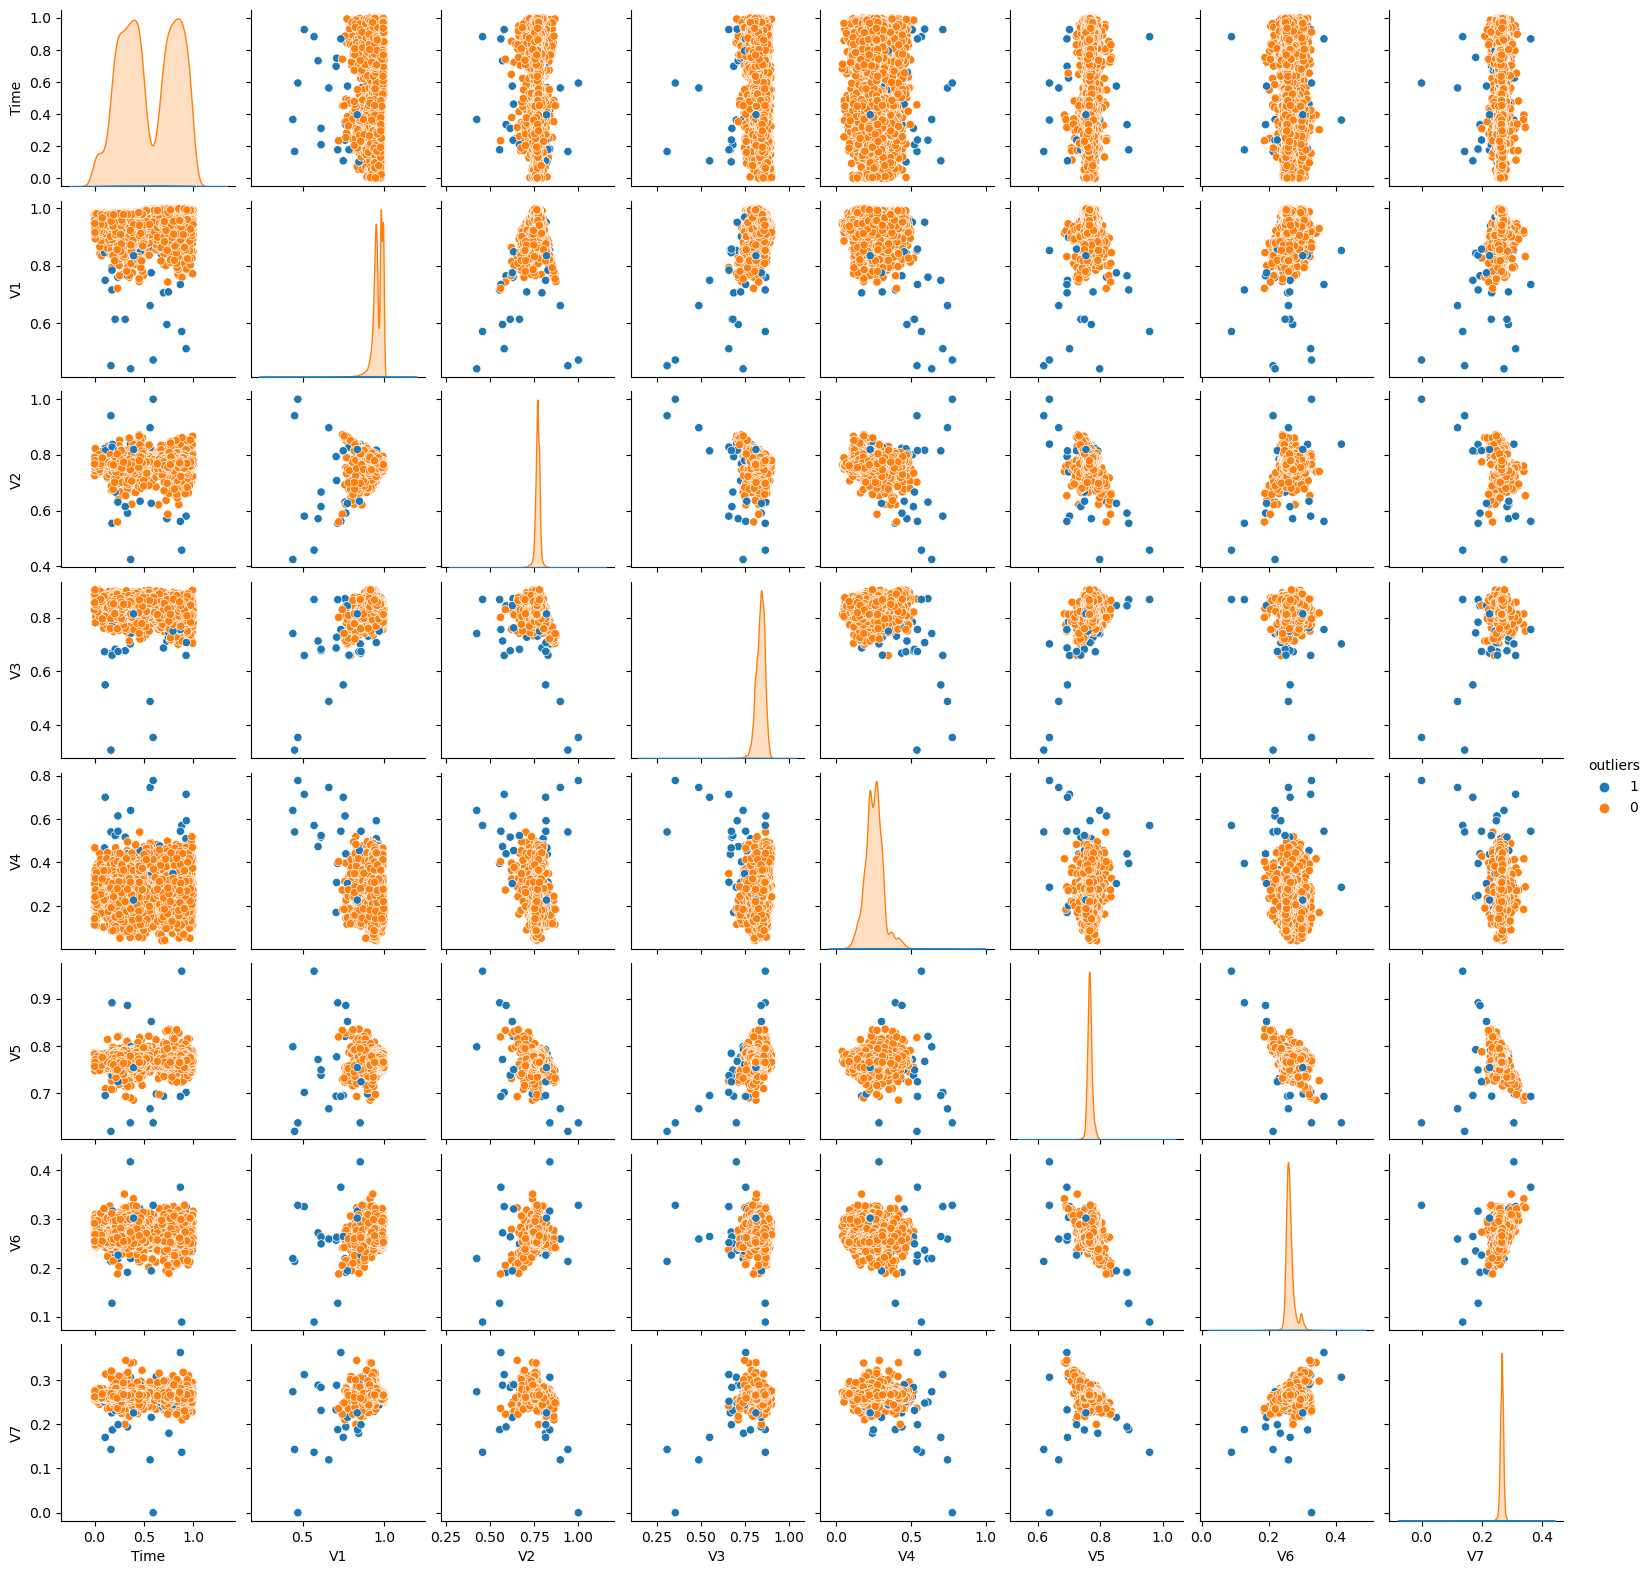

In [26]:
# Формирование матрицы транзакций с атрибутом выброса
num_features = 8
tr_matrix = np.hstack((X_samples[:, :num_features], dbscan_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*data.columns[:num_features], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()

## 5.3. One Class SVM

В результате мы получаем границу, по одну сторону которой лежат максимально "плотные" и похожие друг на друга наблюдения из нашей тренировочной выборки, а по другую будут находится аномальные значения, не похожие на все остальные. Процент таких аномальных наблюдений, которые модель будет пытаться отделить от основной части выборки, мы снова задаём в самом начале обучения при помощи параметра `nu`

In [27]:
from sklearn.svm import OneClassSVM
# Формирование матрицы выбросов
svm_outliers = []
for i in np.arange(0.01, 0.1, 0.02):
    model = OneClassSVM(nu=i, gamma='auto').fit(X_samples)
    svm_outliers.append(np.where(model.predict(X_samples)==-1, 1, 0))

# Подсчет количества и процента выбросов для разных моделей
sum_list = np.array(svm_outliers).sum(axis=1)
mean_list = np.array(svm_outliers).mean(axis=1)

# Сохраняем значения для модели с наименьшим процентом выбросов
svm_outliers = np.array(svm_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('Количество выбросов в выборке: {}'.format(sum_list.min()))
print('Процент выбросов в выборке: {:.2%}'.format(mean_list.min()))

Процент аномальных транзакций в выборке: 0.18%
Количество выбросов в выборке: 113
Процент выбросов в выборке: 0.99%


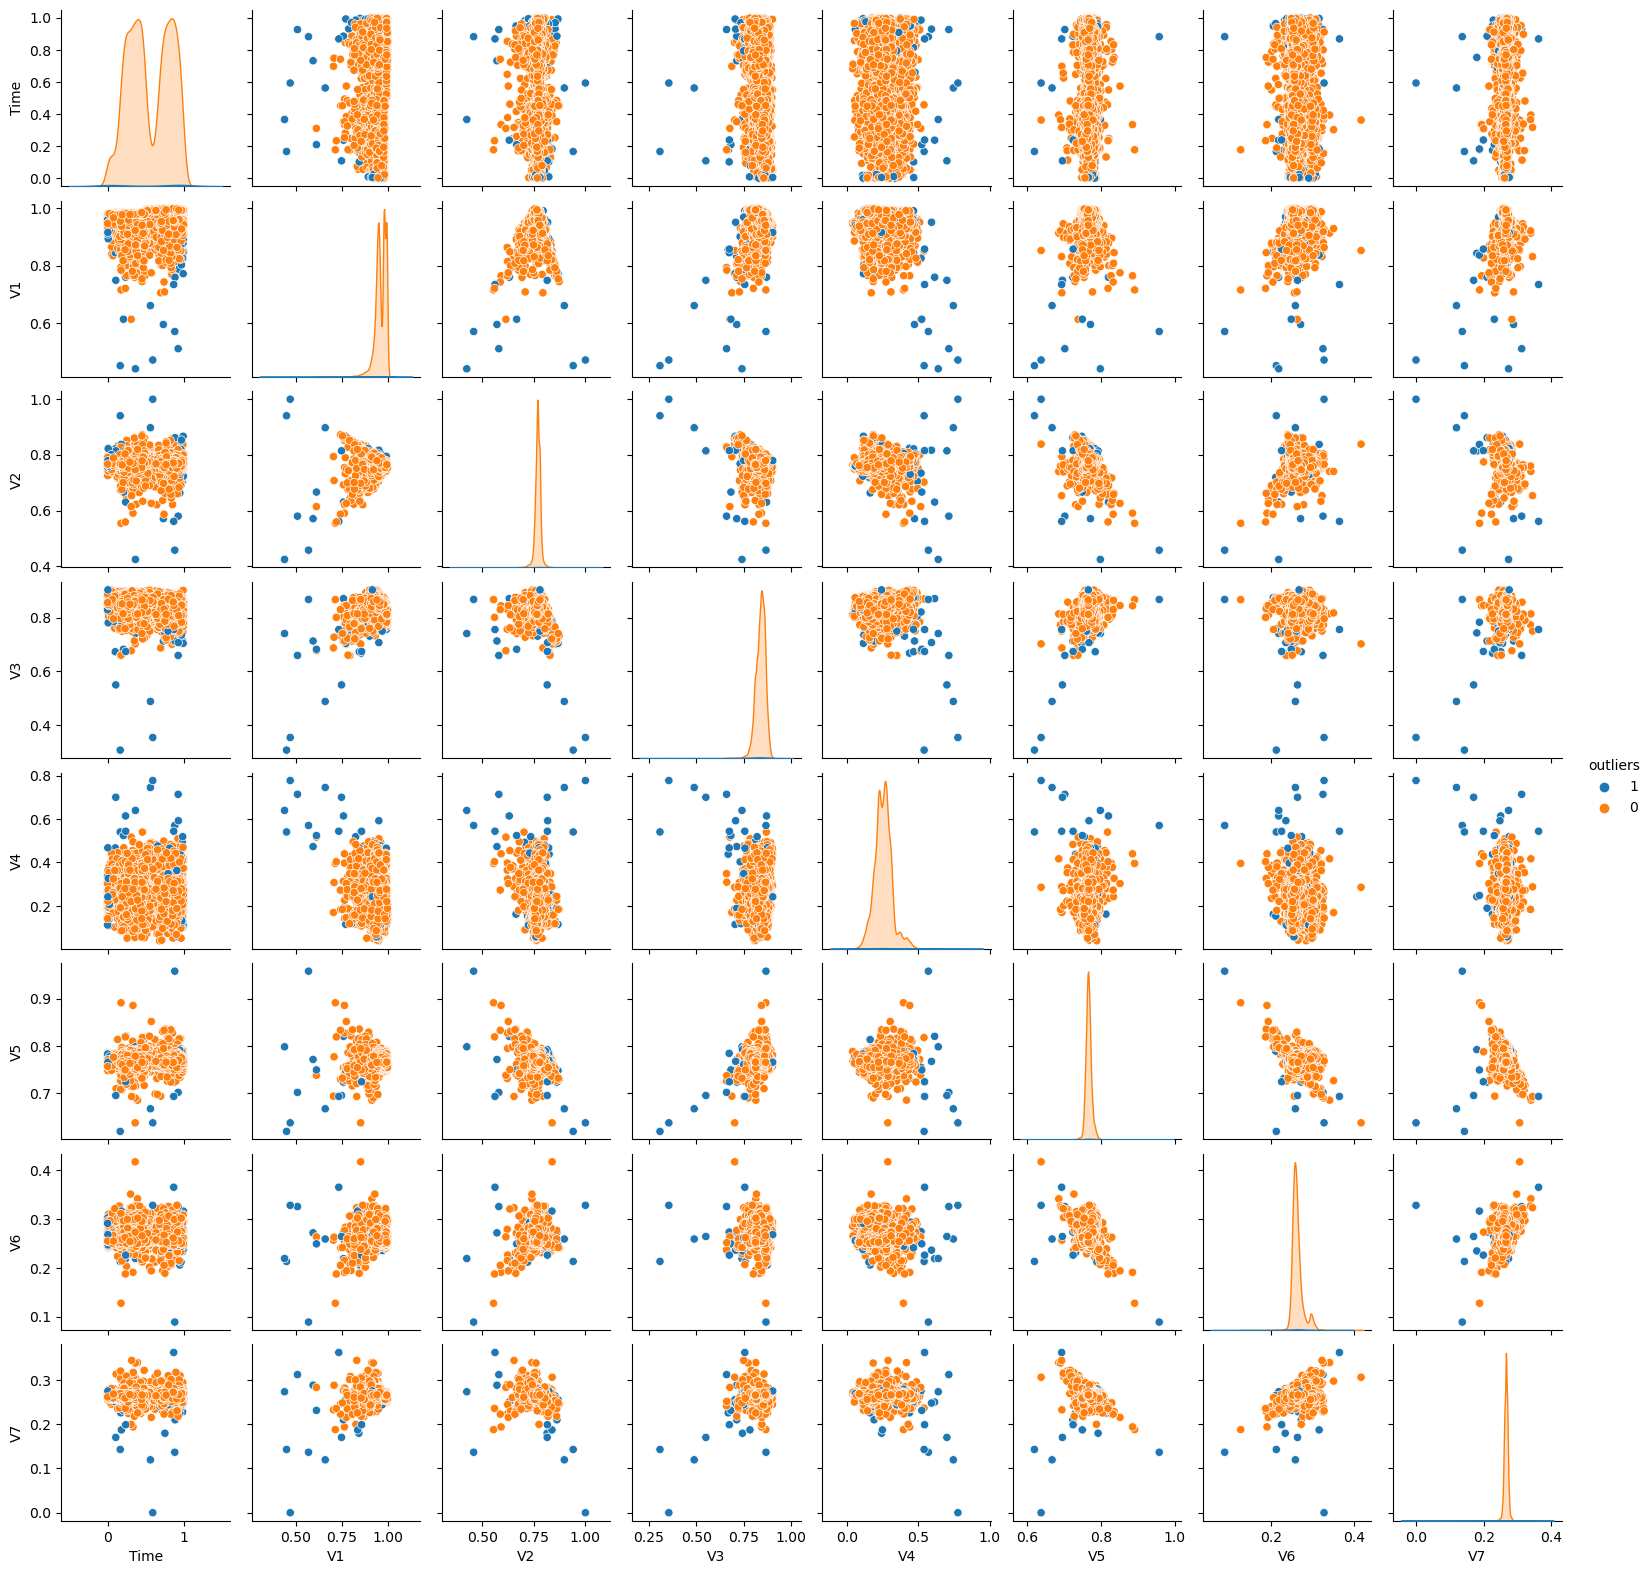

In [28]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :num_features], svm_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*data.columns[:num_features], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()

## 5.4.Isolation Forest

In [29]:
from sklearn.ensemble import IsolationForest

# Формирование матрицы выбросов
forest_outliers = []
for i in np.arange(0.005, 0.05, 0.005):
    model = IsolationForest(n_jobs=-1, contamination=i, random_state=42).fit(X_samples)
    forest_outliers.append(np.where(model.predict(X_samples)==-1, 1, 0))

# Подсчет количества и процента выбросов для разных моделей
sum_list = np.array(forest_outliers).sum(axis=1)
mean_list = np.array(forest_outliers).mean(axis=1)

# Сохраняем значения для модели с наименьшим процентом выбросов
forest_outliers = np.array(forest_outliers)[sum_list.argmin()]

# Вывод информации по аномальным транзакциям и выбросам
print('Процент аномальных транзакций в выборке: {:.2%}'.format(Y_samples.mean()))
print('Количество выбросов в выборке: {}'.format(sum_list.min()))
print('Процент выбросов в выборке: {:.2%}'.format(mean_list.min()))

Процент аномальных транзакций в выборке: 0.18%
Количество выбросов в выборке: 57
Процент выбросов в выборке: 0.50%


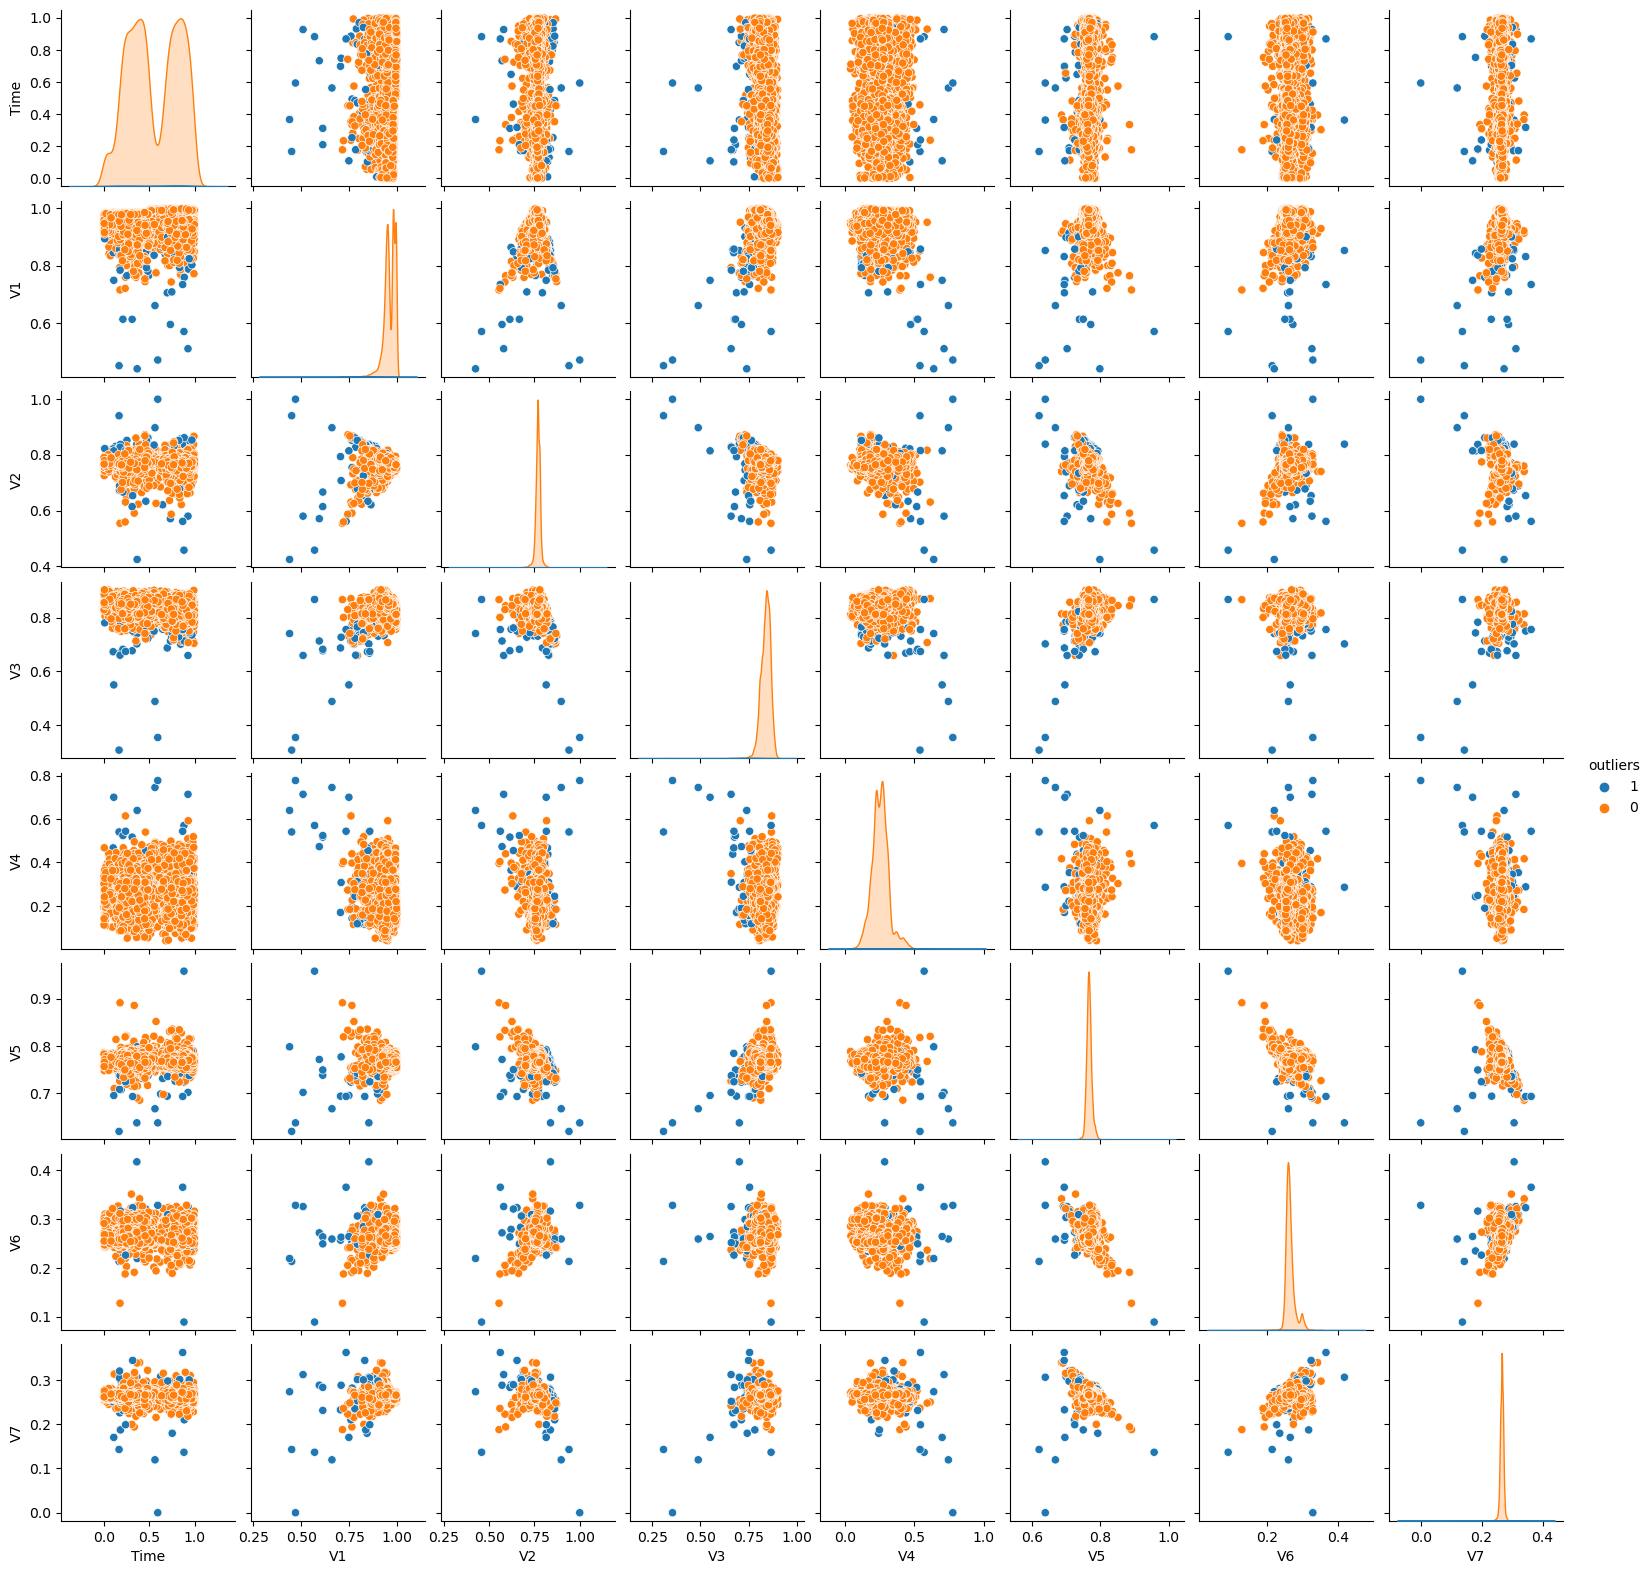

In [30]:
# Формирование матрицы транзакций с атрибутом выброса
tr_matrix = np.hstack((X_samples[:, :num_features], forest_outliers[:, None]))
tr_df = pd.DataFrame(tr_matrix, columns=[*data.columns[:num_features], 'outliers'])

# Отображение парных отношений признаков и их распределение
sns.pairplot(tr_df, hue='outliers', hue_order=[1, 0], height=2)

# Вывод диаграммы
plt.show()

# 6. Финальное сравнение

In [31]:
# Объединение полученных результатов предсказаний по выбросам
outliers = np.vstack([quantile_outliers, dbscan_outliers, svm_outliers, forest_outliers])
titles = ['Межквартильное отклонение', 'Метод DBSCAN', 'Метод One-Class SVM', 'Метод Isolation Forest']

# Сравнение качества моделей по доле выявленных выбросов
outliers_df = pd.DataFrame(np.round(np.hstack([Y_samples.mean(), outliers.mean(axis=1)])[:, None]*100, 2),
                           columns=['Процент'], index=['По выборке', *titles])
outliers_df

Процент
По выборке                    0.18
Межквартильное отклонение     2.20
Метод DBSCAN                  0.43
Метод One-Class SVM           0.99
Метод Isolation Forest        0.50

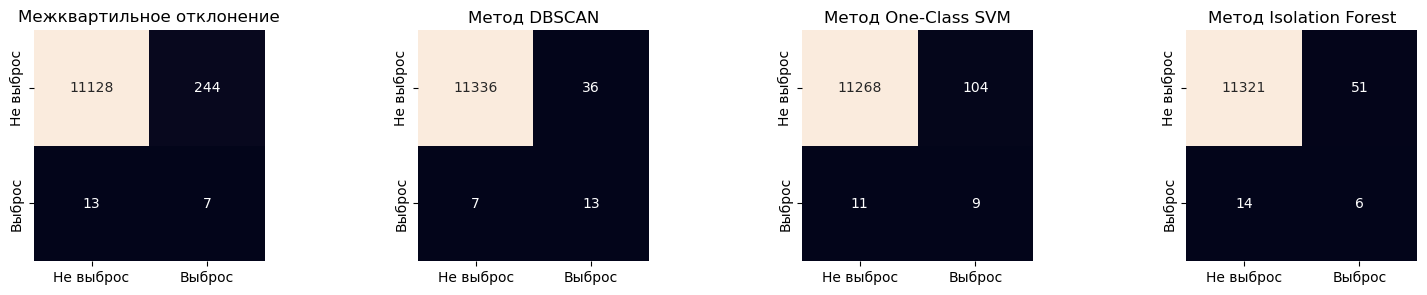

In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Определение размера диаграммы
fig, axes = plt.subplots(1, 4, figsize=(19, 3))

# Вывод матриц ошибок для ранее построенных моделей
for i in range(len(outliers)):
    sns.heatmap(confusion_matrix(Y_samples, outliers[i]), fmt='.0f', 
                xticklabels=['Не выброс', 'Выброс'], yticklabels=['Не выброс', 'Выброс'], 
                ax=axes[i], square=True, cbar=False, annot=True)
    axes[i].set_title(titles[i])
    
# Вывод диаграммы
plt.show()

In [33]:
# Определение переменных
scores = []

# Расчет оценок качества и охвата выбросов моделями
for i in range(len(outliers)):
    scores.append([precision_score(Y_samples, outliers[i]), recall_score(Y_samples, outliers[i]), 
                   f1_score(Y_samples, outliers[i]), roc_auc_score(Y_samples, outliers[i])])

# Вывод точности и охвата прогнозирования моделями выбросов
scores_df = pd.DataFrame(np.array(scores).round(2), 
                         columns=['precision', 'recall', 'f1-score', 'auc-roc'], 
                         index=titles)

# Вывод таблицы оценок моделей
print('Таблица оценок точности и охвата определения выбросов в данных')
scores_df

Таблица оценок точности и охвата определения выбросов в данных


precision  recall  f1-score  auc-roc
Межквартильное отклонение       0.03    0.35      0.05     0.66
Метод DBSCAN                    0.27    0.65      0.38     0.82
Метод One-Class SVM             0.08    0.45      0.14     0.72
Метод Isolation Forest          0.11    0.30      0.16     0.65

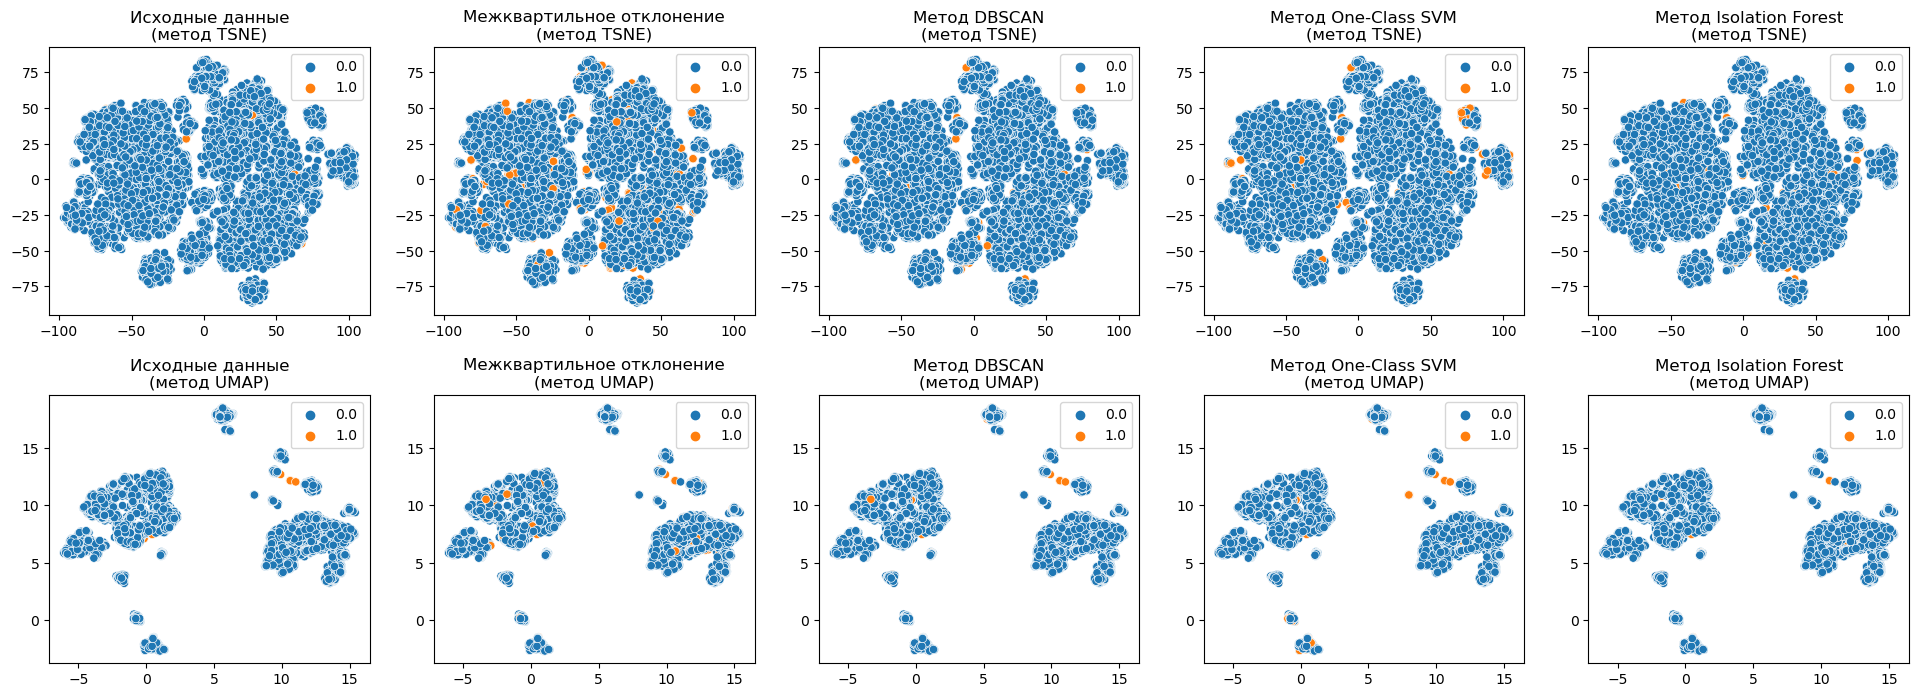

In [34]:
from sklearn.manifold import TSNE
from umap import UMAP
# Добавление исходных данных к визуализации выбросов моделей
outliers = np.vstack([Y_samples, outliers])
titles = ['Исходные данные', *titles]

# Уменьшение размерности признакового пространства методами PCA, TSNE и UMAP
tsne_model = TSNE(n_components=2, random_state=42).fit_transform(X_samples)
umap_model = UMAP(n_components=2, random_state=42).fit_transform(X_samples)

# Определение основных объектов диаграмм
fig, axes = plt.subplots(2, 5, figsize=(24, 8))

# Визуализация выбросов моделей
for i in range(len(outliers)):
    sns.scatterplot(x=tsne_model[:, 0], y=tsne_model[:, 1], ax=axes[0, i % 5], hue=outliers[i])
    sns.scatterplot(x=umap_model[:, 0], y=umap_model[:, 1], ax=axes[1, i % 5], hue=outliers[i])
    axes[0, i % 5].set_title(titles[i] + '\n(метод TSNE)')
    axes[1, i % 5].set_title(titles[i] + '\n(метод UMAP)')

# Увеличение расстояния между диаграммами
plt.subplots_adjust(hspace=0.3)

# Вывод диаграмм
plt.show()


# Выводы:
    1. у DBSCAN процент выбросов составляет 0,43% - это наиболее близкое к проценту выбросов по всей выборке - 0,18%
    2. Классы сильно не сбалансированы, поэтому метрика ROC-AUC является наиболее точно характеризующей качество модели. Для DBSCAN ROC-AUC = 0,82. Это хороший показатель. Как известно, хорошими значениями для ROC-AUC являются значения в диапазоне 0,7-0,95.
    3. Сonfusion matrix для DBSCAN дала минимальное значение как:
    - для ложно-положительных False Positive=36 (нормальная транзакция принимается за мошенническую. В результате ошибки первого рода добросовестным клиентам могут быть отказано в проведении их легитимных транзакций. Это может привести к недовольству клиентов.)
    - так и для ложно-отрицательных наблюдений False Negative = 7 (мошенническая транзакция не обнаруживается и пропускается как нормальная. Последствия ошибки второго рода гораздо более серьезны. Это может привести к потере средств, ухудшению репутации компании и доверия клиентов.
    Таким образом модель DBSCAN показала наилучшие результаты
    4. Преобразование float,int64 в 32, несмотяр на то, что файл уменьшился в 2 раза не решило проблему с памятью. Использование маленькой выборки хорошо справилось с этой задачей и позволило получить результаты на уровне baseline.